# Universidad del Valle de Guatemala
## Facultad de Ingeniería
### Departamento de Computación

---

# Laboratorio 4: CNN

**Integrantes:**
- Diego Alexander Hernández Silvestre, 21270
- Linda Inés Jiménez Vides, 21169

**Curso:** Data Science  
**Sección:** 10  

---

Guatemala, 22 de agosto de 2024


In [5]:
import opendatasets as od
import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random
from os import listdir
import shutil
import numpy as np
import keras.preprocessing.image as kerasImg
import keras.layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import ops
from PIL import Image
from collections import Counter
from keras.utils import to_categorical
from sklearn import svm, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage import shift
from tensorflow.keras.models import load_model
from sklearn.decomposition import PCA
import joblib

### 🚨 Se puede descargar manualmente el dataset mediante el enlace de abajo o ejecutando el código proporcionado. (Es necesario una cuenta y una key de kaggle). Es importante descomprimir el archivo en la carpeta data.
  

In [ ]:
if not os.path.isdir('data'):
    od.download("https://www.kaggle.com/c/nlp-getting-started/data")

### Inciso 1. 🖼️ Carga y visualización de datos

Se extraen las labels de las imágenes, que en este dataset corresponden los números del 0 al 9 y además, se cargan. 

In [3]:
baseDir = './data/PolyMNIST/MMNIST/'

In [6]:
baseDir = './data/PolyMNIST/MMNIST/'
trainDirs = [os.path.join(baseDir, 'train', f'm{i}') for i in range(5)]
testDirs = [os.path.join(baseDir, 'test', f'm{i}') for i in range(5)]

def loadImages(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(np.array(img))
            label = int(filename.split('.')[1]) 
            labels.append(label) 
    return images, labels

trainImages, trainLabels = [], []
for dir in trainDirs:
    images, labels = loadImages(dir)
    trainImages.extend(images)
    trainLabels.extend(labels)

testImages, testLabels = [], []
for dir in testDirs:
    images, labels = loadImages(dir)
    testImages.extend(images)
    testLabels.extend(labels)

Una vez cargadas, se visualizan algunos ejemplos para ver sus características. 

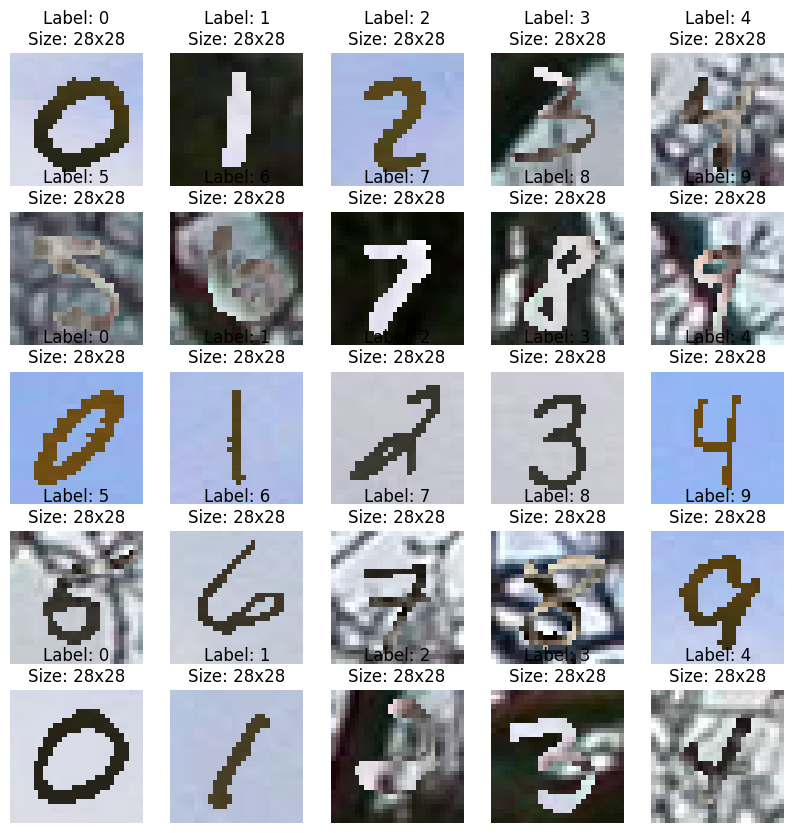

In [14]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(trainImages[i])  
    height, width, _ = trainImages[i].shape
    plt.title(f'Label: {trainLabels[i]}\nSize: {width}x{height}')  
    plt.axis('off')
plt.show()

Guardamos las imágenes en forma binaria.

In [8]:
np.save('MMNIST_train_images.npy', trainImages)
np.save('MMNIST_train_labels.npy', trainLabels)
np.save('MMNIST_test_images.npy', testImages)
np.save('MMNIST_test_labels.npy', testLabels)

Se cargan de forma binaria para que sea más rápido su uso.

In [4]:
trainImages = np.load('MMNIST_train_images.npy')
trainLabels = np.load('MMNIST_train_labels.npy')
testImages = np.load('MMNIST_test_images.npy')
testLabels = np.load('MMNIST_test_labels.npy')

## Inciso 2. 🔍 EDA (Exploratory Data Analysis)

Se identifica el tamaño del dataset. 

In [26]:
def countImagesInDirectory(directory):
    totalImages = 0
    print(f'🔍 Contando imágenes en: {directory}')
    for subdir in os.listdir(directory):
        subdirPath = os.path.join(directory, subdir)
        if os.path.isdir(subdirPath):
            numImages = len(os.listdir(subdirPath))
            print(f'📂 Número de imágenes en {subdirPath}: {numImages}')
            totalImages += numImages
    return totalImages

trainDir = os.path.join(baseDir, 'train')
testDir = os.path.join(baseDir, 'test')
totalTrainImages = countImagesInDirectory(trainDir)
totalTestImages = countImagesInDirectory(testDir)

print(f'📈 Total de imágenes en el conjunto de entrenamiento: {totalTrainImages}')
print(f'📈 Total de imágenes en el conjunto de prueba: {totalTestImages}')

🔍 Contando imágenes en: ./data/PolyMNIST/MMNIST/train
📂 Número de imágenes en ./data/PolyMNIST/MMNIST/train\m0: 60000
📂 Número de imágenes en ./data/PolyMNIST/MMNIST/train\m1: 60000
📂 Número de imágenes en ./data/PolyMNIST/MMNIST/train\m2: 60000
📂 Número de imágenes en ./data/PolyMNIST/MMNIST/train\m3: 60000
📂 Número de imágenes en ./data/PolyMNIST/MMNIST/train\m4: 60000
🔍 Contando imágenes en: ./data/PolyMNIST/MMNIST/test
📂 Número de imágenes en ./data/PolyMNIST/MMNIST/test\m0: 10000
📂 Número de imágenes en ./data/PolyMNIST/MMNIST/test\m1: 10000
📂 Número de imágenes en ./data/PolyMNIST/MMNIST/test\m2: 10000
📂 Número de imágenes en ./data/PolyMNIST/MMNIST/test\m3: 10000
📂 Número de imágenes en ./data/PolyMNIST/MMNIST/test\m4: 10000
📈 Total de imágenes en el conjunto de entrenamiento: 300000
📈 Total de imágenes en el conjunto de prueba: 50000


Se observan los tamaños que tienen las imágenes

In [6]:
def getImageSizesFromArray(imageArray):
    num_images, height, width = imageArray.shape[:3]

    if imageArray.ndim == 4:
        num_images, height, width, channels = imageArray.shape
        sizes = [(height, width, channels)] * num_images
    else:
        sizes = [(height, width)] * num_images
    
    return sizes

trainImageSizes = getImageSizesFromArray(trainImages)
testImageSizes = getImageSizesFromArray(testImages)

print(f'📚 Tamaños de las imágenes en el conjunto de entrenamiento: {trainImageSizes[0]}')
print(f'🧪 Tamaños de las imágenes en el conjunto de prueba: {testImageSizes[0]}')

📚 Tamaños de las imágenes en el conjunto de entrenamiento: (28, 28, 3)
🧪 Tamaños de las imágenes en el conjunto de prueba: (28, 28, 3)


Se analiza la distribución de los tamaños.

In [28]:
def analyzeSizes(imageArray):
    if imageArray.ndim == 4:
        num_images, height, width, channels = imageArray.shape
        sizes = [(width, height)] * num_images
    elif imageArray.ndim == 3:
        num_images, height, width = imageArray.shape
        sizes = [(width, height)] * num_images
    else:
        raise ValueError("Formato de array de imagen no soportado.")

    widths, heights = zip(*sizes)
    avg_width = np.mean(widths)
    avg_height = np.mean(heights)
    std_width = np.std(widths)
    std_height = np.std(heights)
    
    print(f'🔍 Análisis de tamaños:')
    print(f'Promedio de ancho: {avg_width:.2f} px')
    print(f'Promedio de alto: {avg_height:.2f} px')
    print(f'Desviación estándar de ancho: {std_width:.2f} px')
    print(f'Desviación estándar de alto: {std_height:.2f} px')


print("👨‍🏫 Análisis del conjunto de entrenamiento:")
analyzeSizes(trainImages)
print("\n🔬 Análisis del conjunto de prueba:")
analyzeSizes(testImages)


👨‍🏫 Análisis del conjunto de entrenamiento:
🔍 Análisis de tamaños:
Promedio de ancho: 28.00 px
Promedio de alto: 28.00 px
Desviación estándar de ancho: 0.00 px
Desviación estándar de alto: 0.00 px

🔬 Análisis del conjunto de prueba:
🔍 Análisis de tamaños:
Promedio de ancho: 28.00 px
Promedio de alto: 28.00 px
Desviación estándar de ancho: 0.00 px
Desviación estándar de alto: 0.00 px


También se analiza la distribución del dataset para ver si está balanceado. 

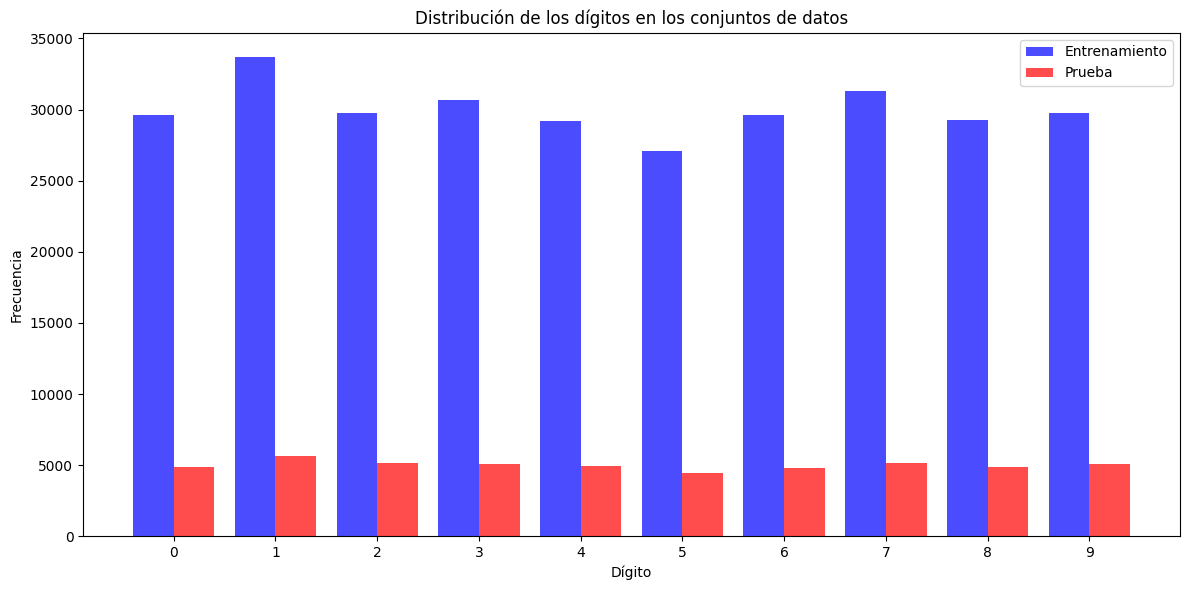

In [29]:
def plotLabelDistribution(trainLabels, testLabels):
    uniqueTrain, countsTrain = np.unique(trainLabels, return_counts=True)
    distribucionTrain = dict(zip(uniqueTrain, countsTrain))
    
    uniqueTest, countsTest = np.unique(testLabels, return_counts=True)
    distribucionTest = dict(zip(uniqueTest, countsTest))
    
    plt.figure(figsize=(12, 6))
    
    plt.bar(np.array(list(distribucionTrain.keys())) - 0.2, distribucionTrain.values(), width=0.4, color='blue', alpha=0.7, label='Entrenamiento')
    plt.bar(np.array(list(distribucionTest.keys())) + 0.2, distribucionTest.values(), width=0.4, color='red', alpha=0.7, label='Prueba')

    plt.xlabel('Dígito')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de los dígitos en los conjuntos de datos')
    plt.xticks(range(10))  # Asegúrate de que todos los dígitos estén representados
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plotLabelDistribution(trainLabels, testLabels)

Como se logra observar, las barras azules indican el conjunto de entrenamiento y la barras rojas el conjunto de prueba. De esta gráfica se logra observar que los datos se encuentran balanceados dado que existen similar cantidad de etiquetas en cada dígito.  

### 🧹 Preprocesamiento de las imágenes

Filtro de escala de grises (los colores no son relevantes)

In [7]:
def convertToGrayscale(imageArray):
    grayscaleImages = []
    for image in imageArray:
        imagePIL = Image.fromarray(image)
        grayscaleImagePIL = imagePIL.convert('L')
        grayscaleImageArray = np.array(grayscaleImagePIL)
        # Añadir una dimensión extra para el canal
        grayscaleImageArray = np.expand_dims(grayscaleImageArray, axis=-1)
        grayscaleImages.append(grayscaleImageArray)
    return np.array(grayscaleImages)

grayscaleTrainImages = convertToGrayscale(trainImages)
grayscaleTestImages = convertToGrayscale(testImages)

print(f'🖼️ Tamaño de imágenes en escala de grises de entrenamiento: {grayscaleTrainImages.shape}')
print(f'🖼️ Tamaño de imágenes en escala de grises de prueba: {grayscaleTestImages.shape}')

np.save('MMNIST_grayscale_train_images.npy', grayscaleTrainImages)
np.save('MMNIST_grayscale_test_images.npy', grayscaleTestImages)


🖼️ Tamaño de imágenes en escala de grises de entrenamiento: (300000, 28, 28, 1)
🖼️ Tamaño de imágenes en escala de grises de prueba: (50000, 28, 28, 1)


In [37]:
import os
import shutil
import numpy as np
from PIL import Image

def organize_images_by_labels(images, labels, output_folder, dataset_type='train'):
    dataset_folder = os.path.join(output_folder, dataset_type)
    if not os.path.exists(dataset_folder):
        os.makedirs(dataset_folder)

    for i in range(10):
        class_folder = os.path.join(dataset_folder, str(i))
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)

    for i in range(images.shape[0]):
        image = images[i]
        label = labels[i]
        class_folder = os.path.join(dataset_folder, str(label))
        image_path = os.path.join(class_folder, f'image_{i}.png')
        img = Image.fromarray(image)
        img.save(image_path)

    print(f'Imágenes del conjunto de datos {dataset_type} organizadas en {output_folder}')

grayscaleTrainImages = np.load('MMNIST_grayscale_train_images.npy') 
trainLabels = np.load('MMNIST_train_labels.npy')

grayscaleTestImages = np.load('MMNIST_grayscale_test_images.npy')
testLabels = np.load('MMNIST_test_labels.npy')

grayscaleTrainImages = np.squeeze(grayscaleTrainImages)
grayscaleTestImages = np.squeeze(grayscaleTestImages)

output_folder = './data/organized_images'

organize_images_by_labels(grayscaleTrainImages, trainLabels, output_folder, dataset_type='train')
organize_images_by_labels(grayscaleTestImages, testLabels, output_folder, dataset_type='test')


Imágenes del conjunto de datos train organizadas en ./data/organized_images
Imágenes del conjunto de datos test organizadas en ./data/organized_images


## Inciso 3. 💻 Creación, entrenamiento y efectividad de modelos de Deep Learning

Modelo proporcionado en el ejemplo de gatos y perros y adaptado para el uso de este laboratorio.

In [103]:
baseDir = './data/organized_images/'

In [121]:

trainLabels = to_categorical(trainLabels, num_classes=10)
testLabels = to_categorical(testLabels, num_classes=10)

In [20]:
modelo1 = keras.Sequential()
modelo1.add(keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
modelo1.add(keras.layers.MaxPooling2D((2, 2)))
modelo1.add(keras.layers.Flatten())
modelo1.add(keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
modelo1.add(keras.layers.Dense(10, activation='softmax'))  

Compilacion del modelo 1

In [21]:
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
modelo1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
modelo1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 320000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    40,960,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,962,314 (156.26 MB)

 Trainable params: 40,962,314 (156.26 MB)

 Non-trainable params: 0 (0.00 B)

### Inciso 6. 📸 Image Augmentation

In [22]:
datagen = ImageDataGenerator(rescale=1.0/255.0)
train_it = datagen.flow_from_directory(baseDir+"train/", class_mode='categorical', batch_size=64, target_size=(200, 200))
test_it = datagen.flow_from_directory(baseDir+"test/", class_mode='categorical', batch_size=64, target_size=(200, 200))

Found 300000 images belonging to 10 classes.
Found 50000 images belonging to 10 classes.


Entramiento y guardado del modelo 1

In [23]:
history = modelo1.fit(train_it, steps_per_epoch=train_it.samples//train_it.batch_size, validation_data=test_it, validation_steps=test_it.samples//test_it.batch_size, epochs=5, verbose=True)
modelo1.save(baseDir + 'modelo1.keras')

Epoch 1/5
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 985s 210ms/step - accuracy: 0.7826 - loss: 0.8142 - val_accuracy: 0.8743 - val_loss: 0.4074
Epoch 2/5
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - accuracy: 0.9062 - loss: 0.2932 - val_accuracy: 0.9375 - val_loss: 0.2352
Epoch 3/5
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 983s 210ms/step - accuracy: 0.9066 - loss: 0.2959 - val_accuracy: 0.8921 - val_loss: 0.3669
Epoch 4/5
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 0s 16us/step - accuracy: 0.8906 - loss: 0.3286 - val_accuracy: 0.8750 - val_loss: 0.5375
Epoch 5/5
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 937s 200ms/step - accuracy: 0.9273 - loss: 0.2268 - val_accuracy: 0.8941 - val_loss: 0.3874


In [24]:
loss , acc = modelo1.evaluate(test_it, steps=len(test_it), verbose=1)
print('> %.3f' % (acc * 100.0))

782/782 ━━━━━━━━━━━━━━━━━━━━ 48s 62ms/step - accuracy: 0.8945 - loss: 0.3890
> 89.408


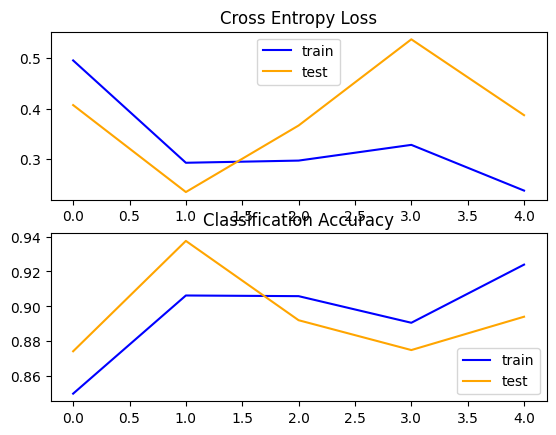

In [25]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.legend()
 # plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.legend()

Como se puede ver en ambas gráficas en el Cross Entropy Loss se observa como la perdida en el entrenamiento disminuye inicialmente, lo que sugiere que el modelo aprende en las primeras epocas, sin embargo llega un momento donde la perdida aumenta, indicando que el modelo puede estar sobreajustandose o encontrando dificultades para mejorar.

La perdida del conjunto de prueba tambien disminuye al inicio pero aumenta bruscamente despues de la epoca 1, lo cual puede ser un indicio de sobreajuste también.

En el Classification Accuracy en el entrenamiento la presición mejora desde la primer época pero luego oscila hasta la última. Esto nos dice que el modelo podría estar memorizando el conjunto de entrenamiento en lugar de generalizar bien.

Ahora con el conjunto de prueba la precisión aumenta rápidamenta al inicio pero disminuye despues de la primer época, lo cual dice que puede estar sobreajustado el modelo.

In [45]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam

# Definir el modelo VGG16 compacto
_input = Input(shape=(200, 200, 1))  # Imágenes en escala de grises, tamaño 200x200

# Primer bloque
conv1  = Conv2D(filters=8, kernel_size=(3, 3), padding="same", activation="relu")(_input)
conv2  = Conv2D(filters=8, kernel_size=(3, 3), padding="same", activation="relu")(conv1)
pool1  = MaxPooling2D((2, 2))(conv2)

# Segundo bloque
conv3  = Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation="relu")(pool1)
conv4  = Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation="relu")(conv3)
pool2  = MaxPooling2D((2, 2))(conv4)

# Tercer bloque
conv5  = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(pool2)
conv6  = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(conv5)
pool3  = MaxPooling2D((2, 2))(conv6)

# Capa de aplanamiento
flat   = Flatten()(pool3)

# Capas densas
dense1 = Dense(128, activation="relu")(flat)
output = Dense(10, activation="softmax")(dense1)  # 10 clases

vgg16_model = Model(inputs=_input, outputs=output)

In [46]:
opt = Adam(learning_rate=0.0001)
vgg16_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
vgg16_model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 200, 200, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 200, 200, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 200, 200, 8)    │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 100, 100, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 100, 100, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 100, 100, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 50, 50, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 50, 50, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │     2,560,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,579,458 (9.84 MB)

 Trainable params: 2,579,458 (9.84 MB)

 Non-trainable params: 0 (0.00 B)

### Inciso 6. 📸 Image Augmentation

In [47]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

train_it = datagen.flow_from_directory(baseDir+"train/", color_mode='grayscale', class_mode='categorical', batch_size=64, target_size=(200, 200))
test_it = datagen.flow_from_directory(baseDir+"test/", color_mode='grayscale', class_mode='categorical', batch_size=64, target_size=(200, 200))

Found 300000 images belonging to 10 classes.
Found 50000 images belonging to 10 classes.


In [48]:
history = vgg16_model.fit(train_it, steps_per_epoch=train_it.samples // train_it.batch_size, validation_data=test_it, validation_steps=test_it.samples // test_it.batch_size, epochs=5, verbose=True)
vgg16_model.save(baseDir + 'modelo_vgg16.keras')

Epoch 1/5
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 656s 140ms/step - accuracy: 0.7710 - loss: 0.7288 - val_accuracy: 0.9514 - val_loss: 0.1551
Epoch 2/5
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/step - accuracy: 0.9531 - loss: 0.1702 - val_accuracy: 0.8125 - val_loss: 0.5761
Epoch 3/5


C:\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


4687/4687 ━━━━━━━━━━━━━━━━━━━━ 591s 126ms/step - accuracy: 0.9652 - loss: 0.1110 - val_accuracy: 0.9661 - val_loss: 0.1085
Epoch 4/5
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.9844 - loss: 0.0338 - val_accuracy: 1.0000 - val_loss: 0.0197
Epoch 5/5
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 621s 133ms/step - accuracy: 0.9822 - loss: 0.0548 - val_accuracy: 0.9690 - val_loss: 0.1029


In [50]:
loss , acc = vgg16_model.evaluate(test_it, steps=len(test_it), verbose=1)
print('> %.3f' % (acc * 100.0))

782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.9680 - loss: 0.1070
> 96.898


In [59]:
loss_train, acc_train = vgg16_model.evaluate(train_it, steps=len(train_it), verbose=1)

print('Accuracy over the training set:', round((acc_train * 100), 2), '%')


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 188s 40ms/step - accuracy: 0.9910 - loss: 0.0304
Accuracy over the training set: 99.09 %


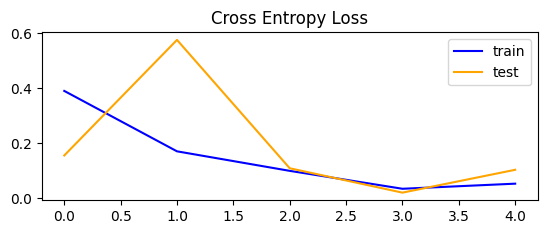

In [54]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.legend()

Para el Cross Entropy Loss podemos ver que para el entrenamiento, la pérdida disminuye constantemente a lo largo de las épocas, lo cual es buena señal de que el modelo está aprendiendi de manera efectiva.

Con el conjunto de prueba al inicio la pérdida aumenta desde la primer época, lo que puede decir que el modelo se esta sobreajustando en esa estapa, aunque luego de la segunda época la pérdida disminuye de forma significativa y se estabilia, leggando a valores cercanos a los del conjunto de entrenamiento. 

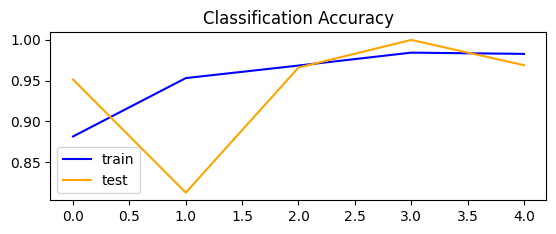

In [114]:
 # plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.legend()

Para el Classification Accuracy el conjunto de entrenamiento la presición mejora de manera constante y se mantiene alta (0.98) en lass útlimas épocas, indicando que el modelo alcanza un buen rendimiento.

Para el conjunto de prueba la presición del conjunto sigue un comportamiento bastante similar al de la pérdida, despues de una caída inicial en la primer época, se recupera y se alinea algo similar con la de entrenamiento en las últimas épocas. Esta recuperación nos dice que aunque hay posibilidad que esta sobreajustado al iniciso, se logró ajustar los parámetros para mejorar la generalización.

## Inciso 4. 🧠 Red neuronal simple 

In [122]:
from tensorflow.keras.models import Sequential

redNeuronalSimple = Sequential()
redNeuronalSimple.add(Flatten(input_shape=(200, 200, 1)))  
redNeuronalSimple.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))  
redNeuronalSimple.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))  
redNeuronalSimple.add(Dense(10, activation='softmax'))  

In [123]:
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
redNeuronalSimple.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
redNeuronalSimple.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_14 (Flatten)            │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │     5,120,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,129,034 (19.57 MB)

 Trainable params: 5,129,034 (19.57 MB)

 Non-trainable params: 0 (0.00 B)

### Inciso 6. 📸 Image Augmentation

In [124]:
datagen = ImageDataGenerator(rescale=1.0/255.0)
train_it = datagen.flow_from_directory(baseDir+"train/", class_mode='categorical', batch_size=64, target_size=(200, 200), color_mode='grayscale')
test_it = datagen.flow_from_directory(baseDir+"test/", class_mode='categorical', batch_size=64, target_size=(200, 200), color_mode='grayscale')

Found 300000 images belonging to 10 classes.
Found 50000 images belonging to 10 classes.


In [125]:
history_simple = redNeuronalSimple.fit(train_it, 
                                   steps_per_epoch=train_it.samples//train_it.batch_size, 
                                   validation_data=test_it, 
                                   validation_steps=test_it.samples//test_it.batch_size, 
                                   epochs=10, 
                                   verbose=True)
redNeuronalSimple.save(baseDir + 'RedNeuronalSimple.keras')

Epoch 1/10
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 203s 43ms/step - accuracy: 0.3211 - loss: 1.9002 - val_accuracy: 0.4430 - val_loss: 1.6407
Epoch 2/10
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - accuracy: 0.4219 - loss: 1.6363 - val_accuracy: 0.1875 - val_loss: 1.8565
Epoch 3/10


C:\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


4687/4687 ━━━━━━━━━━━━━━━━━━━━ 125s 27ms/step - accuracy: 0.4503 - loss: 1.6272 - val_accuracy: 0.5047 - val_loss: 1.4878
Epoch 4/10
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.7031 - loss: 1.0036 - val_accuracy: 0.4375 - val_loss: 1.5340
Epoch 5/10
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 124s 26ms/step - accuracy: 0.5101 - loss: 1.5061 - val_accuracy: 0.5339 - val_loss: 1.4404
Epoch 6/10
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.3594 - loss: 1.7890 - val_accuracy: 0.7500 - val_loss: 0.9348
Epoch 7/10
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 119s 25ms/step - accuracy: 0.5247 - loss: 1.4647 - val_accuracy: 0.5526 - val_loss: 1.4322
Epoch 8/10
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step - accuracy: 0.5938 - loss: 1.2522 - val_accuracy: 0.6250 - val_loss: 1.1397
Epoch 9/10
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 119s 25ms/step - accuracy: 0.5646 - loss: 1.3922 - val_accuracy: 0.5790 - val_loss: 1.3522
Epoch 10/10
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step - accuracy: 0.5156 - loss: 1.4112 

In [127]:
loss , acc = redNeuronalSimple.evaluate(test_it, steps=len(test_it), verbose=1)
print('> %.3f' % (acc * 100.0))

782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5767 - loss: 1.3617
> 57.696


La red neuronal obtuvo una presición del 57.7% en el conjutno de prueba, el cual es un valor bajo y nos dice que el modelo tiene dificultades para generalizar y clasificar correctamente datos no vistos.

In [128]:
loss_train, acc_train = redNeuronalSimple.evaluate(train_it, steps=len(train_it), verbose=1)
print('> Training set:', round((acc_train * 100), 3), '%')

4688/4688 ━━━━━━━━━━━━━━━━━━━━ 86s 18ms/step - accuracy: 0.5723 - loss: 1.3704
> Training set: 57.258 %


El conjunto de entrenamiento la presición es del 57.3% siendo solo un poco mejor a la presición anterior. Esto nos dice que el modelo no esta sobreajustado pero tampoco aprende patrones que mejoren la clasificación.

Podemos ver que ambos valores de pérdida, tanto de entrenamiento y prueba son cifras algo altas para tareas de clasificación, lo que puede decir que el modelo no está aprendiendo bien y hace predicciones poco confiables.

## Inciso 5. 🟢 SVM

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import scipy.stats
import joblib

baseDir = './data/organized_images/'

# Cargar imágenes y etiquetas desde archivos .npy
print('Cargando imágenes y etiquetas desde archivos .npy...')
trainImages = np.load('MMNIST_grayscale_train_images.npy')
trainLabels = np.load('MMNIST_train_labels.npy')
testImages = np.load('MMNIST_grayscale_test_images.npy')
testLabels = np.load('MMNIST_test_labels.npy')
print('Imágenes y etiquetas cargadas correctamente.')

# Función para extraer estadísticas básicas de cada imagen
def extract_basic_features(images):
    features = []
    for image in images:
        # Extraer estadísticas básicas con NumPy y SciPy
        mean = np.mean(image)
        std = np.std(image)
        var = np.var(image)
        skew = scipy.stats.skew(image.flatten())  # Asimetría
        kurt = scipy.stats.kurtosis(image.flatten())  # Curtosis
        features.append([mean, std, var, skew, kurt])
    return np.array(features)

# Extraer características básicas de las imágenes
print('Extrayendo características básicas de las imágenes de entrenamiento...')
trainImages_features = extract_basic_features(trainImages)
print('Extrayendo características básicas de las imágenes de prueba...')
testImages_features = extract_basic_features(testImages)

# Escalar las características usando scikit-learn
print('Escalando las características...')
scaler = StandardScaler()
trainImages_features = scaler.fit_transform(trainImages_features)
testImages_features = scaler.transform(testImages_features)

# Aplicar PCA para reducir la dimensionalidad usando scikit-learn
print('Aplicando PCA para reducir la dimensionalidad...')
pca = PCA(n_components=3)  # Número de componentes a mantener
trainImages_pca = pca.fit_transform(trainImages_features)
testImages_pca = pca.transform(testImages_features)

# Entrenar el modelo de Regresión Logística usando scikit-learn
print('Entrenando el modelo de Regresión Logística...')
model = LogisticRegression()
model.fit(trainImages_pca, trainLabels)
print('Modelo de Regresión Logística entrenado con éxito.')

# Guardar el modelo usando joblib
model_filename = baseDir + 'logistic_regression_model.pkl'
joblib.dump(model, model_filename)
print(f'Modelo de Regresión Logística guardado en {model_filename}')


Cargando imágenes y etiquetas desde archivos .npy...
Imágenes y etiquetas cargadas correctamente.
Extrayendo características básicas de las imágenes de entrenamiento...
Extrayendo características básicas de las imágenes de prueba...
Escalando las características...
Aplicando PCA para reducir la dimensionalidad...
Entrenando el modelo de Regresión Logística...
Modelo de Regresión Logística entrenado con éxito.
Modelo de Regresión Logística guardado en ./data/organized_images/logistic_regression_model.pkl


In [3]:
# Evaluar la precisión del modelo en el conjunto de prueba
accuracy = model.score(testImages_pca, testLabels)
print(f'Precisión en el conjunto de prueba: {accuracy}')

Precisión en el conjunto de prueba: 0.13846


Para el último se utilizó el algoritmo de regresión logística, ya que previamente se había probado con SVM pero estuvo corriendo aproximandamente 16 horas y no terminó de entrenarse, por lo que se decidió cambiar a regresión logística el cual despues de 4 min logró terminar de entrenarse pero eso sí corriendo el riesgo que no fuera tan bueno. 

Como se puede ver en la presisión este es del casi 14% lo cual es bastante bajo y no tan buen modelo.

### Inciso 6. 📸 Image Augmentation

In [19]:
# Configurar el ImageDataGenerator para augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,      # Rotación aleatoria
    width_shift_range=0.2,  # Desplazamiento horizontal
    height_shift_range=0.2, # Desplazamiento vertical
    shear_range=0.2,        # Cortar imagen
    zoom_range=0.2,         # Zoom
    horizontal_flip=True,   # Voltear horizontalmente
    fill_mode='nearest'     # Rellenar los píxeles vacíos
)

train_it = datagen.flow_from_directory(
    baseDir + "train/",
    class_mode='categorical',
    batch_size=64,
    target_size=(200, 200),
    color_mode='grayscale'
)

test_it = datagen.flow_from_directory(
    baseDir + "test/",
    class_mode='categorical',
    batch_size=64,
    target_size=(200, 200),
    color_mode='grayscale'
)

Found 300000 images belonging to 10 classes.
Found 50000 images belonging to 10 classes.


In [34]:
from sklearn.metrics import accuracy_score

# Etiquetas verdaderas (ground truth)
true_labels = []
predicted_labels = []

# Procesar cada batch de imágenes
for batch_images, batch_labels in test_it:
    # Extraer características básicas de las imágenes
    def extract_basic_features(images):
        features = []
        for image in images:
            mean = np.mean(image)
            std = np.std(image)
            var = np.var(image)
            skew = scipy.stats.skew(image.flatten())
            kurt = scipy.stats.kurtosis(image.flatten())
            features.append([mean, std, var, skew, kurt])
        return np.array(features)
    
    # Extraer características de cada batch de imágenes
    batch_features = extract_basic_features(batch_images)
    
    # Escalar las características usando el scaler ya entrenado (fit)
    batch_features = scaler.transform(batch_features)
    
    # Aplicar PCA usando el PCA ya ajustado
    batch_pca = pca.transform(batch_features)
    
    # Realizar predicciones con el modelo LogisticRegression ya entrenado
    predictions = model.predict(batch_pca)
    
    # Guardar las predicciones y etiquetas verdaderas
    predicted_labels.extend(predictions)
    true_labels.extend(np.argmax(batch_labels, axis=1))
    
    # Detener el loop cuando se han procesado todas las imágenes
    if len(true_labels) >= test_it.samples:
        break

# Calcular el accuracy del modelo
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy del modelo con imágenes aumentadas: {accuracy * 100:.2f}%')


Accuracy del modelo con imágenes aumentadas: 12.78%


Como se puede ver el accuracy con image augmentation es del 12.78% disminuyendo a comparación del modelo original. Esta disminución puede deberse a que las transformaciones introducen ruido y variabilidad que un modelo simple como la regresión logística no puede manejar de manera efectiva ya que de por si su presición ya era baja. Dado que es un modelo lineal, no tiene la capacidad para generalizar con datos más complejos, como imágenes rotadas o desplazadas, lo que lo llega a confundir. Todo esto combinado con la limitada capacidad del modelo para capturar patrones complejos, nos puede decir el por qué de que el rendimiento empeoró con el image augmentation

## Inciso 7. 📚 Ingreso de números.

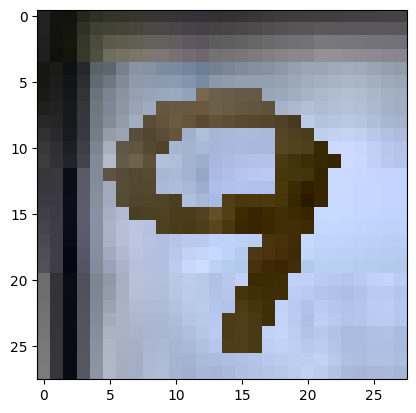

In [83]:
name = "data/PolyMNIST/MMNIST/test/m4/3.9.png"
foto = imread(name)
plt.imshow(foto)

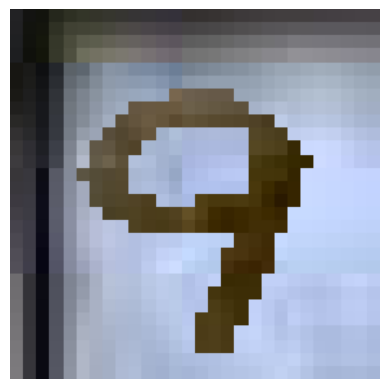

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
El modelo predice que es un: 9
Probabilidades para cada clase (0-9): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [84]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as kerasImg

# Cargar y preprocesar la imagen
imagen = kerasImg.load_img(name, target_size=(200, 200))
plt.imshow(imagen)
plt.axis('off')  # Opcional: para ocultar los ejes en la imagen mostrada
plt.show()

imagen = kerasImg.img_to_array(imagen)
imagen = imagen.reshape(1, 200, 200, 3)  # Redimensionar para que sea compatible con el modelo

# Hacer la predicción
resultado = modelo1.predict(imagen)

# Obtener la clase con la probabilidad más alta
prediccion = np.argmax(resultado)

# Mostrar el resultado
print(f"El modelo predice que es un: {prediccion}")

# Imprimir las probabilidades (opcional)
print(f"Probabilidades para cada clase (0-9): {resultado[0]}")


Como se puede ver ambos modelos de deep learning realizados son los mejores en cuanto a presición versus la red neuronal y la regresión logística, por lo que realizando una prueba de predicción con el primer modelo de deep learning se puede ver que realizó bien la predicción.